In [1]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt

In [5]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="SA"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'



In [6]:
xr.open_dataset(hr_path)    

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 14600, bnds: 2, lon: 128, lat: 128)
Coordinates:
  * time       (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31...
  * lon        (lon) float32 512B 20.5 20.6 20.7 20.8 ... 32.9 33.0 33.1 33.2
  * lat        (lat) float32 512B -34.7 -34.6 -34.5 -34.4 ... -22.2 -22.1 -22.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 234kB ...
    lon_bnds   (lon, bnds) float32 1kB ...
    lat_bnds   (lat, bnds) float32 1kB ...
    crs        int32 4B ...
    pr         (time, lat, lon) float64 2GB ...
    tasmax     (time, lat, lon) float32 957MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Thu Sep 25 09:29:15 2025: cdo mergetime pr_tasmax_c...
    source:               CSIRO conformal-cubic model. Input file: ccam_8.km....
    Conventions:          CF-1.11
    title:                CCAM simulation data
    il:                   192
    ...                   ...
    ateb_ac_deltat:       1.0
    ateb_ac_heatcap:      10.0
    ateb_acfactor:        2.0
    ateb_alpha:           1.0
    ateb_lwintmeth:       2
    ateb_cvcoeffmeth:     1

In [7]:
xr.open_dataset(hr_path).time[:(14610//2)]

<xarray.DataArray 'time' (time: 7305)> Size: 58kB
array(['1961-01-01T12:00:00.000000000', '1961-01-02T12:00:00.000000000',
       '1961-01-03T12:00:00.000000000', ..., '2080-01-03T12:00:00.000000000',
       '2080-01-04T12:00:00.000000000', '2080-01-05T12:00:00.000000000'],
      shape=(7305,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 58kB 1961-01-01T12:00:00 ... 2080-01-05T12...
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T

Processing pr
torch.Size([14600, 128, 128])
torch.Size([14600, 128, 128])
dtypes torch.float32 torch.float32
Processing tasmax
torch.Size([14600, 128, 128])
torch.Size([14600, 128, 128])
dtypes torch.float32 torch.float32


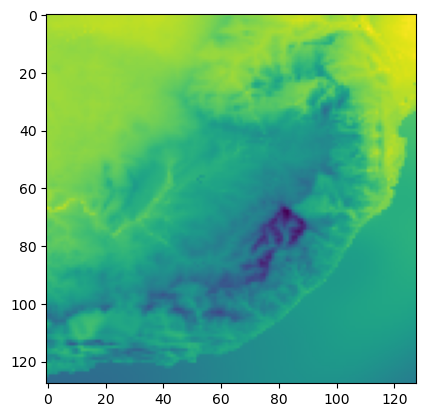

In [10]:
hr_ds = xr.open_dataset(hr_path).astype("float32")
for data_type in ["pr", "tasmax"]:
    print(f"Processing {data_type}")
    hr_data = torch.from_numpy(hr_ds[data_type].data)
    print(hr_data.shape)
    hr_data = torch.flip(hr_data, [1])
    print(hr_data.shape)
    if data_type in ["pr"]:
        hr_data = torch.sqrt(hr_data)

    # COMPUTE NORM STATS        
    hr_std_all = torch.std(hr_data)
    hr_mean_all = torch.mean(hr_data)

    if data_type in ["pr"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"

    torch.save({"mean": hr_mean_all, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_{file_base}.pt"))

    hr_std_pw = torch.std(hr_data, dim=0)
    hr_mean_pw = torch.mean(hr_data, dim=0)
    
    print("dtypes", hr_mean_pw.dtype, hr_std_pw.dtype)
    
    torch.save({"mean": hr_mean_pw, "std": hr_std_pw},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_pixelwise_{file_base}.pt"))

    hr_norm = (hr_data - hr_mean_pw) / hr_std_pw
    plt.imshow(hr_norm[0, :, :].detach().numpy())
    plt.imshow(hr_mean_pw.detach().numpy())
    

In [ ]:
# path: /r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt

In [ ]:
import torch

In [12]:
hr_path = "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_ESD_pseudo_reality_tasmax_CNRM-CM5_1961-1980.pt"
torch.load(hr_path)

{'mean': tensor([[284.4966, 284.4994, 284.5131,  ..., 284.9285, 284.8103, 284.6643],
         [284.5666, 284.4833, 284.4336,  ..., 284.6558, 284.6160, 284.6700],
         [284.5297, 284.5656, 284.5123,  ..., 284.5303, 284.4581, 284.2696],
         ...,
         [292.2213, 292.3362, 292.1060,  ..., 291.2505, 291.3974, 291.3417],
         [292.7937, 292.7127, 292.3658,  ..., 291.3436, 291.3183, 291.3217],
         [293.1352, 294.0338, 294.9068,  ..., 291.3980, 291.3814, 291.3858]]),
 'std': tensor([[ 4.3915,  4.4047,  4.4396,  ..., 11.4857, 11.3968, 11.4888],
         [ 4.3307,  4.3590,  4.3766,  ..., 11.3970, 11.3853, 11.4522],
         [ 4.2934,  4.3030,  4.3249,  ..., 11.3842, 11.3542, 11.4067],
         ...,
         [ 4.1865,  4.2892,  4.2611,  ...,  4.7079,  4.6755,  4.6924],
         [ 4.8835,  5.1558,  4.8274,  ...,  4.6925,  4.6775,  4.6736],
         [ 6.8761,  6.9324,  6.7984,  ...,  4.6675,  4.6746,  4.6691]])}

In [6]:
hr_path = "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_pixelwise_tasmax_train_ALL.pt"
torch.load(hr_path)["mean"].shape

torch.Size([128, 128])

In [21]:
lr_path = f'{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
lr_ds = xr.open_dataset(lr_path).astype("float32")

for data_type in lr_ds.data_vars.keys():
    if data_type == "time_bnds":
        continue
    print(f"Processing {data_type}")
    lr_data = torch.flip(torch.from_numpy(lr_ds[data_type].data), [1])
        
    if data_type in ["pr", "sfcWind"]:
        lr_data = torch.sqrt(lr_data)

    if data_type in ["pr", "sfcWind"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    # COMPUTE NORM STATS
    lr_std_all = torch.std(lr_data)
    lr_mean_all = torch.mean(lr_data)
    
    #torch.save({"mean": hr_mean_all, "std": hr_std_all},
    #    os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_{file_base}.pt"))
    
    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
    print(os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_{file_base}.pt"))
    torch.save({"mean": lr_mean_all, "std": lr_std_all},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_{file_base}.pt"))
    
    lr_std_pw = torch.std(lr_data, dim=0)
    lr_mean_pw = torch.mean(lr_data, dim=0)

    torch.save({"mean": lr_mean_pw, "std": lr_std_pw},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_pixelwise_{file_base}.pt"))

Processing t_500
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_t_500_ACCESS-CM2_1961-1980.pt
Processing t_700
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_t_700_ACCESS-CM2_1961-1980.pt
Processing t_850
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_t_850_ACCESS-CM2_1961-1980.pt
Processing u_500
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_u_500_ACCESS-CM2_1961-1980.pt
Processing u_700
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_u_700_ACCESS-CM2_1961-1980.pt
Processing u_850
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_full-data_ESD_pseudo_reality_u_850_ACCESS-CM2_1961-1980.pt
Processing v_500
/r/scratch/users/mschillinger/data/cordexbench/SA/norm_stats/lr_norm_stats_fu

## Norm stats per period

In [7]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt

In [8]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="ALPS"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_ds = xr.open_dataset(hr_path).astype("float32")

lr_path = f'{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
lr_ds = xr.open_dataset(lr_path).astype("float32")

In [9]:
for data_type in ["tasmax"]:
    print(f"Processing {data_type}")
    hr_data = torch.from_numpy(hr_ds[data_type].data)
    print(hr_data.shape)
    hr_data = torch.flip(hr_data, [1])
    print(hr_data.shape)
    if data_type in ["pr"]:
        hr_data = torch.sqrt(hr_data)

    # COMPUTE NORM STATS        
    
    # get only first half of data
    index_half = hr_data.shape[0] // 2
    
    hr_std_all = torch.std(hr_data)
    hr_mean_first = torch.mean(hr_data[:index_half])
    hr_mean_second = torch.mean(hr_data[index_half:])

    if data_type in ["pr"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"

    torch.save({"mean": hr_mean_first, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_past_{file_base}.pt"))
    torch.save({"mean": hr_mean_second, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_future_{file_base}.pt"))

Processing tasmax
torch.Size([14610, 128, 128])
torch.Size([14610, 128, 128])


In [10]:
for data_type in lr_ds.data_vars.keys():
    if data_type == "time_bnds":
        continue
    print(f"Processing {data_type}")
    lr_data = torch.flip(torch.from_numpy(lr_ds[data_type].data), [1])
        
    if data_type in ["pr", "sfcWind"]:
        lr_data = torch.sqrt(lr_data)

    if data_type in ["pr", "sfcWind"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    index_half = lr_data.shape[0] // 2
    # COMPUTE NORM STATS
    lr_std_all = torch.std(lr_data)
    lr_mean_first = torch.mean(lr_data[:index_half])
    lr_mean_second = torch.mean(lr_data[index_half:])    
    
    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
    print(os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_{file_base}.pt"))
    torch.save({"mean": lr_mean_first, "std": lr_std_all},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_past_{file_base}.pt"))
    torch.save({"mean": lr_mean_second, "std": lr_std_all},
        os.path.join(root, domain, "norm_stats", f"lr_norm_stats_full-data_future_{file_base}.pt"))

Processing u_850
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_850_CNRM-CM5_1961-1980_2080-2099.pt
Processing u_700
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_700_CNRM-CM5_1961-1980_2080-2099.pt
Processing u_500
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_u_500_CNRM-CM5_1961-1980_2080-2099.pt
Processing v_850
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_850_CNRM-CM5_1961-1980_2080-2099.pt
Processing v_700
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_700_CNRM-CM5_1961-1980_2080-2099.pt
Processing v_500
/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/lr_norm_stats_full-data_Emulator_hist_future_v_500_CNRM-CM5_1961-1980_2080-2099.pt
Processing q_850
/r/sc

In [15]:
hr_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 14610, y: 128, x: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
    lon      (y, x) float64 131kB ...
    lat      (y, x) float64 131kB ...
  * x        (x) float64 1kB 2.062e+03 2.075e+03 ... 3.638e+03 3.65e+03
  * y        (y) float64 1kB 1.412e+03 1.425e+03 1.438e+03 ... 2.988e+03 3e+03
Data variables:
    tasmax   (time, y, x) float32 957MB 287.6 288.5 289.9 ... 281.3 281.1 280.9
    pr       (time, y, x) float32 957MB 5.118 3.732 2.501 ... 6.426 6.528 6.407
Attributes: (12/26)
    description:                    Created by xios
    title:                          Created by xios
    Conventions:                    CF-1.6
    creation_date:                  2018-10-24T11:26:47Z
    name:                           EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r...
    institute_id:                   CNRM
    ...                             ...
    references:                     http://www.umr-cnrm.fr/spip.php?article12...
    comment:                        CORDEX Europe EUR-11 CNRM-ALADIN 6.3 L91 ...
    c3s_disclaimer:                 This data has been produced in the contex...
    driving_experiment_comment:     Known issue correction: this simulation (...
    frequency:                      day
    tracking_id:                    hdl:21.14103/e0344943-4520-4786-94f8-4cbf...

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np
# spatial means lr, hr
lr_mean = lr_ds.to_array().mean(dim=["lat", "lon"])
hr_mean = hr_ds.to_array().mean(dim=["x", "y"])

# Features: lr_mean variables over time -> shape (n_time, n_features)
X_feat = lr_mean.transpose("time", "variable").values
# Target: hr_mean tasmax over time -> shape (n_time,)
y_tas = hr_mean.sel(variable="tasmax").values

# Evaluate and plot
X_feat_train = X_feat[:len(X_feat)//2]
y_tas_train = y_tas[:len(y_tas)//2]
lin = LinearRegression()
lin.fit(X_feat_train, y_tas_train)

# Inspect top contributing predictors
var_names = lr_mean["variable"].values
coef = lin.coef_
top_idx = np.argsort(np.abs(coef))[::-1][:5]
print("Top predictors (by |coef|):")
for i in top_idx:
    print(f"  {var_names[i]}: {coef[i]:.4f}")

Top predictors (by |coef|):
  t_850: 3.2285
  v_700: -1.0454
  t_500: -0.9295
  z_700: -0.7918
  u_700: -0.7246


In [17]:
coef

array([ 1.7823930e-01, -7.2460300e-01,  5.1616937e-01,  5.7938921e-01,
       -1.0453631e+00,  4.1989505e-01,  3.9521189e-04, -9.0294506e-04,
       -5.0655857e-04,  3.2285438e+00, -3.9479551e-01, -9.2947453e-01,
        5.6168514e-01, -7.9182780e-01,  2.3695159e-01], dtype=float32)

In [21]:
data_type = "tasmax"
file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
torch.save({"coef": coef, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_coef_past_{file_base}.pt"))

In [22]:
# also save predictions for Ymean based on future LR predictors

X_feat_future = X_feat[len(X_feat)//2:]
y_tas_pred_future = lin.predict(X_feat_future)
hr_mean_estimated = np.mean(y_tas_pred_future)

torch.save({"mean": hr_mean_estimated, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_future-estimated_{file_base}.pt"))

In [24]:
print(hr_mean_estimated)

291.75073


## Get norm stats from linear model predictions

In [ ]:
# /r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_preds_20260204-181430.nc
import xarray as xr
# linear_pred = xr.open_dataset("/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_preds_20260204-191852.nc")
linear_pred = xr.open_dataset("/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/trained_on_past/ridge_pr_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_preds.nc")

Note: 
- variable in pr linear predictions was accidentally also named tasmax_ridge_pred
- predictions were already squared

In [ ]:
training_experiment = 'Emulator_hist_future'
data_type = "pr"
gcm_name = 'CNRM-CM5'
period_training = '1961-1980_2080-2099'
name_str = ""
file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
root = "/r/scratch/users/mschillinger/data/cordexbench/"
domain = "ALPS"

In [3]:
linear_pred

<xarray.Dataset> Size: 958MB
Dimensions:            (time: 14610, y: 128, x: 128)
Coordinates:
  * time               (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 20...
  * y                  (y) float64 1kB 1.412e+03 1.425e+03 ... 2.988e+03 3e+03
  * x                  (x) float64 1kB 2.062e+03 2.075e+03 ... 3.65e+03
Data variables:
    tasmax_ridge_pred  (time, y, x) float32 957MB ...

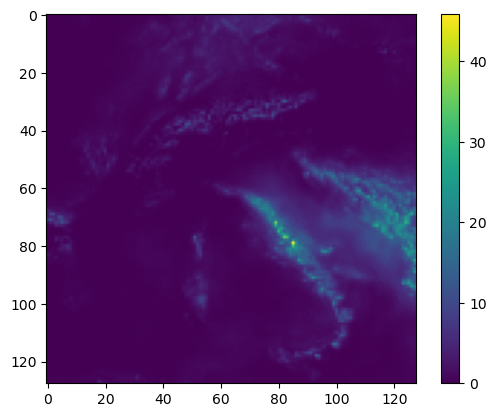

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.flip(linear_pred["tasmax_ridge_pred"].values, [1])[100, :, :]);
plt.colorbar();

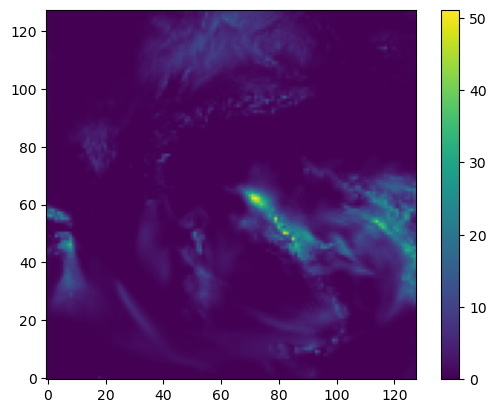

In [13]:
folder = "train"
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_ds = xr.open_dataset(hr_path).astype("float32")
plt.imshow(hr_ds["pr"].values[100, :, :], origin="lower");
plt.colorbar();

In [5]:
import torch
import os 
import numpy as np
torch.save({"pred": torch.tensor(
        np.flip(linear_pred["tasmax_ridge_pred"].values[(14610//2):], [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_future-estimated_{file_base}.pt"))
torch.save({"pred": torch.tensor(
        np.flip(linear_pred["tasmax_ridge_pred"].values[:(14610//2)], [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_past_{file_base}.pt"))

torch.save({"pred": torch.tensor(
        np.flip(linear_pred["tasmax_ridge_pred"].values, [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_all_{file_base}.pt"))

In [7]:
# for pr, also save sqrt transformed predictions
name_str = "_sqrt"
file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"
torch.save({"pred": torch.tensor(
        np.flip(
                np.sqrt(linear_pred["tasmax_ridge_pred"].values[(14610//2):]), 
                [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_future-estimated_{file_base}.pt"))
torch.save({"pred": torch.tensor(
        np.flip(np.sqrt(linear_pred["tasmax_ridge_pred"].values[:(14610//2)]), [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_past_{file_base}.pt"))
torch.save({"pred": torch.tensor(
        np.flip(np.sqrt(linear_pred["tasmax_ridge_pred"].values), [1]).copy())},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_linear-pred_all_{file_base}.pt"))